In [1]:
import numpy as np

In [2]:
## Simulate from the Poisson regression model (use y,X)
def get_poisson (n,p):
    """
    get the poisson distribution 
    """
    X = np.random.normal(0,1,size = (n,p))
    beta = np.matrix(np.random.normal(0,.2,size = (p))).T
    lamb = np.exp(X @ beta)
    y = np.matrix(np.random.poisson(lamb)).T
    return (beta, X, y)

In [3]:
def gradient (beta, x, y):
    return x.T.dot(np.exp(x.dot(beta))-y)

In [4]:
def norm(a):
    return np.linalg.norm(a)

In [5]:
def gradient_descent_1 (w,eita,X,y,limit):
    
    
    r_0 = norm(w)
    error = 0.0000001
    r_0_error = r_0 * error


    for i in range (0,limit) : 
        gradient_for_one = gradient(w,X,y)
        norm_for_one = norm(gradient_for_one)
        if (norm_for_one < r_0_error):
            break
        else :
            w = w - eita * gradient_for_one;
    print(i)
    return w

In [6]:
def get_mse(n):
    beta_one, x_one, y_one = get_poisson (n,20)
    beta = gradient_descent_1 (beta_one,0.0001,x_one, y_one,1000)
    mse_beta = np.mean(np.power(y_one - x_one @ beta , 2))
    mse_beta_ori = np.mean(np.power(y_one - x_one @ beta_one , 2))
    return mse_beta_ori, mse_beta

In [9]:
mse_beta_ori_3000, mse_beta_3000 = get_mse(1000)
(mse_beta_ori_3000 - mse_beta_3000)/mse_beta_ori_3000

308


0.1379278593427804

In [10]:
mse_beta_ori_300, mse_beta_300 = get_mse(100)
(mse_beta_ori_300 - mse_beta_300)/mse_beta_ori_300

999


0.18832712258452516

Notice that the difference between the mse original (which is generated from the true $\beta$) and mse (which is generated from the true $\hat \beta$) is smaller when n = 3000 compares with n = 300.

Thus from the result above we can say that the estimated $\hat \beta$ approaches the true $\beta$ with large n value. 

In [11]:
import pickle
with open('hw2.data','rb') as f:
    y_tr,X_tr_ori,y_te,X_te_ori = pickle.load(f)

In [12]:
X_tr_ori.shape

(1000, 100)

### 1 OLS

In [13]:
#normalize the norm 
from numpy import linalg 
X_tr_norm = linalg.norm(X_tr_ori, axis=0)
X_te_norm = linalg.norm(X_te_ori, axis=0)

X_tr = X_tr_ori / X_tr_norm
X_te = X_te_ori / X_te_norm

In [14]:
from sklearn import linear_model, neighbors
regmod_1 = linear_model.LinearRegression(fit_intercept=False) 
regmod_1.fit(X_tr,y_tr)
y_hat = regmod_1.predict(X_te)

In [15]:
#MSE for test error
mse = np.sum((y_hat - y_te)**2)/1000
mse

1.0411444900270803

Thus the MSE for OLS is 1.0411444900270803

### 2 Ridge

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import lars_path, LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import scale 
import matplotlib.pyplot as plt

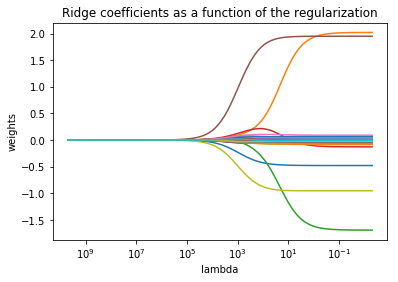

In [17]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_tr), y_tr)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

From the graph above, we can see when we should consider alpha in range 10 to 0.1. Or ideally, 5 to 0.05, since the lines of weights different most at those values.

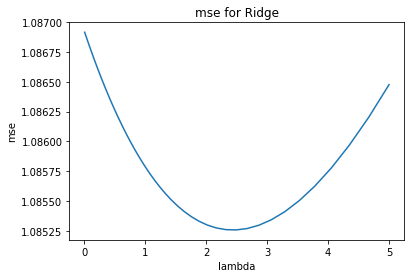

In [46]:
ridge = Ridge()
alphas = 10**np.linspace(1,-2,100)*0.5

mse = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_tr), y_tr)
    y_hat = ridge.predict(scale(X_te))
    mse.append(np.mean(np.power((y_hat - y_te),2)))

plt.plot(alphas,mse)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.title('mse for Ridge');
plt.show()

In [19]:
loc = mse.index(min(mse))
mse[loc],alphas[loc]

(1.0852568959766649, 2.488511782166056)

Thus the lowest mse for ridge regression is 1.0852568959766649, with it's alpha value 2.488511782166056

### 3 Lasso

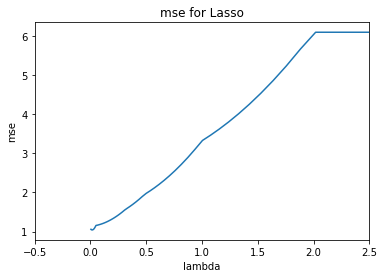

In [20]:
lasso = Lasso()

mse_lasso = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_tr), y_tr)
    y_hat = lasso.predict(scale(X_te))
    mse_lasso.append(np.mean(np.power((y_hat - y_te).data,2)))

plt.plot(alphas,mse_lasso)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.title('mse for Lasso');
plt.xlim((-0.5,2.5))
plt.show()

In [21]:
min(mse_lasso)

1.0438813816481483

In [22]:
loc = mse_lasso.index(min(mse_lasso))
mse_lasso[loc],alphas[loc]

(1.0438813816481483, 0.01637274581438864)

Thus the lowest mse for ridge regression is 1.0438813816481483, with it's alpha value 0.01637274581438864

### 4 
Compare and contrast the lars path to the lasso path, what is the key difference. Tell me when the active sets differ and how, if they do at all.

In [23]:
def plot_lars(coefs, lines=False, title="Lars Path"):
    """
    Plot the lasso path where coefs is a matrix - the columns are beta vectors
    """
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    if lines:
        plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(title)
    plt.axis('tight')

(-1, 1)

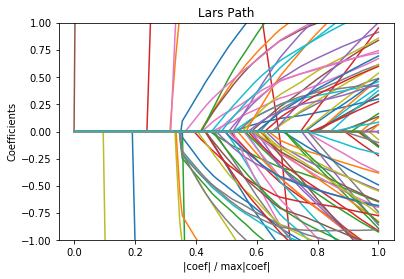

In [47]:
alphas_lars, _, coefs_lars = lars_path(X_tr,y_tr)
plot_lars(coefs_lars)
plt.ylim((-1,1))

(-1, 1)

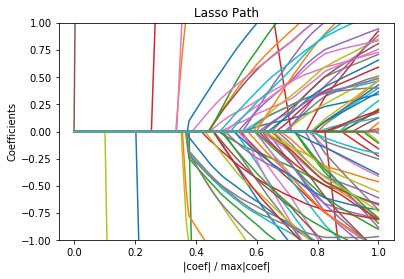

In [48]:
alphas_lasso, _, coefs_lasso = lars_path(X_tr,y_tr,method='lasso')
plot_lars(coefs_lasso,title="Lasso Path")
plt.ylim((-1,1))

Since when coefficient = 0, the line in Lasso path is apart when comparing to Lars (especially notice serveral red lines ). Thus several line in both graph are different, which might caused by the difference between Lars and Lasso. (Lars do not delete coefficients from the model, where as Lasso do. Recall that in Lasso coefficient is deleted from the model and will be added back into the model again. )


### 5 
Extract each active set from the lasso path and recompute the restricted OLS for each. Compute and compare the test error for each model.

In [31]:
lassocv = LassoCV(cv=None)
lassocv.fit(scale(X_tr_ori),y_tr)
alphas = lassocv.alphas

In [34]:
def decision (a):
    X_tr_red_ori = X_tr_ori[:,lasso.coef_ > a]
    X_te_red_ori = X_te_ori[:,lasso.coef_ > a]
    
    X_tr_red_norm = linalg.norm(X_tr_red_ori, axis=0)
    X_te_red_norm = linalg.norm(X_te_red_ori, axis=0)

    X_tr_red = X_tr_red_ori / X_tr_red_norm
    X_te_red = X_te_red_ori / X_te_red_norm
     
    regmod_1.fit(X_tr_red,y_tr)
    y_hat = regmod_1.predict(X_te_red)
    return np.mean(np.sum((y_hat - y_te)**2))/1000

In [35]:
decision(0.0)

2.5221283939929235

The best active set has mse 2.5221283939929235

### 6
If  a more parsimonious model is desired(a smaller model) then I would choose the best active set from Lasso method, and recompute the restricted OLS on the best active set, which is provide me with small coeffients but also able to explain most of the data.